In [44]:
# set path
import os
import pandas as pd
import csv; import numpy as np
import re

path = '/Users/andiedonovan/myProjects/Youtube_Python_Project/AndiesBranch/'
os.chdir(path) # change directory

# load in data

# training data
okgo = pd.read_csv('data/OKGO.csv', delimiter=";", skiprows=2, encoding='latin-1', engine='python') # read in the data
trump = pd.read_csv('data/trump.csv', delimiter=",", skiprows=2, encoding='utf-8', error_bad_lines=False, engine='python')
swift = pd.read_csv('data/TaylorSwift.csv', delimiter=",", skiprows=2, nrows=180, encoding='utf-8', engine='python')
royal = pd.read_csv('data/RoyalWedding.csv', delimiter=",", skiprows=2, nrows=61, encoding='utf-8', engine='python')
paul = pd.read_csv('data/LoganPaul.csv', delimiter=",", skiprows=2, nrows=200, encoding='utf-8', engine='python')
blogs = pd.read_csv('data/Kagel.csv', delimiter=",", skiprows=2, encoding='latin-1', engine='python') # read in the data
tweets = pd.read_csv('data/twitter.csv', delimiter=",", skiprows=2, encoding='latin-1', engine='python') # read in the data

# test data:
#trump = pd.read_csv('data/trump.csv', delimiter="@@@", skiprows=2, encoding='utf-8', error_bad_lines=False, engine='python')
# combine training dataframes
df = pd.read_csv('data/data.csv', delimiter="@@@", skiprows=2, encoding='utf-8', engine='python')

# clean dataframes
tweets = tweets.drop(['Topic', 'TweetId', "TweetDate"], axis = 1).dropna()

def fix_cols(DF):
    DF = DF.iloc[:,:2]
    DF.columns = ["label", "comment"]
    return DF

okgo = fix_cols(okgo)
trump = fix_cols(trump)
swift = fix_cols(swift)
royal = fix_cols(royal)
paul = fix_cols(paul)
tweets = fix_cols(tweets)

tweets.label = tweets.label.replace({'positive': '1.0', 'negative':'-1.0', 'neutral': '0.0', 'irrelevant': '0.0'}, regex=True)
tweets['label'] = pd.to_numeric(tweets['label'], errors='coerce')

videos = pd.concat([okgo, trump, swift, royal, paul], ignore_index=True)
data = videos.copy()
data = fix_cols(data)

df.columns = ["comment", "label"]

#DataList = [videos, full, videos_not_royal, videos_not_okgo]
#excluded = [okgo, royal]

# clean up textual data (remove symbols)
def AsStr(DF):
    DF["comment"]= DF["comment"].astype(str)

AsStr(data)
AsStr(df)

def cleanerFn(b):
    for row in range(len(b)):
        line = b.loc[row, "comment"]
        b.loc[row,"comment"] = re.sub("[^a-zA-Z]", " ", line)

cleanerFn(df)
cleanerFn(data)
data = data.dropna()

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
import sklearn # machine learning
from sklearn.model_selection import train_test_split # splitting up data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

sw = stopwords.words('english')
ps = PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
tfidf = TfidfVectorizer(max_features=250,ngram_range=(1, 2))

def nlpFunction(a):
    a['com_token']=a['comment'].str.lower().str.split()
    a['com_remv']=a['com_token'].apply(lambda x: [y for y in x if y not in sw])
    a["com_lemma"] = a['com_remv'].apply(lambda x : [lemmatizer.lemmatize(y) for y in x]) # lemmatization
    a['com_stem']=a['com_lemma'].apply(lambda x : [ps.stem(y) for y in x]) # stemming
    a["com_stem_str"] = a["com_stem"].apply(', '.join)
    return a

df = nlpFunction(df)
data = nlpFunction(data)
trump = nlpFunction(trump)

X_train = data["com_stem_str"]
Y_train = data["label"]
X_user = df["com_stem_str"]

xtrain = tfidf.fit_transform(X_train) # transform and fit training data
#xtest = tfidf.transform(X_test) # transform test data from fitted transformer
xuser = tfidf.transform(X_user)
#data_trans= tfidf.transform(data["com_stem_str"]) # transform entire dataset for cross validation
#df_trans = tfidf.transform(df["com_stem_str"])


# running models
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm # support vector machine
from sklearn import metrics # for accuracy/ precision
#from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent
from sklearn.neighbors import KNeighborsClassifier # k-NN ensemble method
from sklearn.ensemble import RandomForestClassifier

import pickle

'''os.chdir(path)
lr= pickle.load(open('dash/lr.pkl', 'rb'))
#mnb=pickle.load(open('dash/mnb.pkl', 'rb'))
#rf= pickle.load(open('dash/rf.pkl', 'rb'))
#knn= pickle.load(open('dash/knn.pkl', 'rb'))
#svm= pickle.load(open('dash/svm.pkl', 'rb'))'''

#from sklearn.grid_search import GridSearchCV
from scipy.stats import randint, expon, uniform
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rs = 42
lr = LogisticRegression(solver='sag', max_iter=100, random_state=rs, multi_class="multinomial")
mnb = MultinomialNB()
svm = svm.SVC()
rf = RandomForestClassifier(n_estimators=10, random_state=rs)
knn = KNeighborsClassifier()

models = ['lr', 'mnb', 'svm', 'rf', 'knn']
labels = ['label_' + str(models[i]) for i in range(0,len(models))]
predictions = [str(models[i])+"_predict" for i in range(0,len(models))]
d = {}
initModels = [lr, mnb, svm, rf, knn]

for i in range(0,5):
    initModels[i].fit(xtrain, Y_train)
    d[predictions[i]] = initModels[i].predict(xuser)

    # Create table of prediction accuracy rates
Table = pd.DataFrame(columns=['comment', 'label_lr', 'label_mnb', 'label_svm', 'label_rf', 'label_knn'])
for i in range(0, len(models)):
    Table[labels[i]] = d[predictions[i]]
Table["comment"] = df["comment"]

# Create table of predicted sentiment ratios
Ratios = pd.DataFrame(columns=['label_lr', 'label_mnb', 'label_svm', 'label_rf', 'label_knn'],
    index=range(0,3))
def RatioFinder(model):
    pos = Table[Table[model]== 1.0]
    neg = Table[Table[model]== -1.0]
    neu = Table[Table[model]== 0.0]

    pos_len = len(pos); neg_len = len(neg); neu_len = len(neu)
    total = pos_len + neg_len + neu_len

    neg_ratio = round(neg_len / float(total), 2) * 100
    pos_ratio = round(pos_len / float(total), 2) * 100
    neu_ratio = round(neu_len / float(total), 2) * 100

    ratios = [pos_ratio, neu_ratio, neg_ratio]
    return ratios

for i in range(0,3):
        for j in range(0,5):
            Ratios.iloc[i,j] = RatioFinder(labels[j])[i]

all_models = pd.DataFrame(columns=['average'], index=range(0,3))
all_models["average"]= Ratios.mean(axis=1)

# set the prediction to the mode of the row
Table["Prediction"] = 0
Table["Prediction"] = Table[['label_lr','label_mnb','label_svm','label_rf','label_knn']].mode(axis=1)
df.label = Table["Prediction"]

# extracting comments for each label
df["com_remv"] = df["com_remv"].apply(', '.join)
df["com_remv"] = df["com_remv"].str.replace(",","").astype(str)

'''df_words = df[["label","com_remv"]]
positive = df_words[df_words["label"]==1.0]
neutral = df_words[df_words["label"]==0.0]
negative = df_words[df_words["label"]==-1.0]
'''
p = df[df["label"]==1]
positive = p["com_remv"]
n = df[df["label"]==-1]
negative = n["com_remv"]
ne = df[df["label"]==0]
neutral = ne["com_remv"]

# most frequent words in each label
most_freq_pos = pd.Series(' '.join(positive).lower().split()).value_counts()[:10]
most_freq_neg = pd.Series(' '.join(negative).lower().split()).value_counts()[:10]
most_freq_neu = pd.Series(' '.join(neutral).lower().split()).value_counts()[:10]

print(Table.head(3))
# set path
import os
import pandas as pd
import csv; import numpy as np
import re

path = '/Users/andiedonovan/myProjects/Youtube_Python_Project/AndiesBranch/'
os.chdir(path) # change directory

# load in data

# training data
okgo = pd.read_csv('data/OKGO.csv', delimiter=";", skiprows=2, encoding='latin-1', engine='python') # read in the data
trump = pd.read_csv('data/trump.csv', delimiter=",", skiprows=2, encoding='utf-8', error_bad_lines=False, engine='python')
swift = pd.read_csv('data/TaylorSwift.csv', delimiter=",", skiprows=2, nrows=180, encoding='utf-8', engine='python')
royal = pd.read_csv('data/RoyalWedding.csv', delimiter=",", skiprows=2, nrows=61, encoding='utf-8', engine='python')
paul = pd.read_csv('data/LoganPaul.csv', delimiter=",", skiprows=2, nrows=200, encoding='utf-8', engine='python')
blogs = pd.read_csv('data/Kagel.csv', delimiter=",", skiprows=2, encoding='latin-1', engine='python') # read in the data
tweets = pd.read_csv('data/twitter.csv', delimiter=",", skiprows=2, encoding='latin-1', engine='python') # read in the data

# test data:
#trump = pd.read_csv('data/trump.csv', delimiter="@@@", skiprows=2, encoding='utf-8', error_bad_lines=False, engine='python')
# combine training dataframes
df = pd.read_csv('data/data.csv', delimiter="@@@", skiprows=2, encoding='utf-8', engine='python')

# clean dataframes
tweets = tweets.drop(['Topic', 'TweetId', "TweetDate"], axis = 1).dropna()

def fix_cols(DF):
    DF = DF.iloc[:,:2]
    DF.columns = ["label", "comment"]
    return DF

okgo = fix_cols(okgo)
trump = fix_cols(trump)
swift = fix_cols(swift)
royal = fix_cols(royal)
paul = fix_cols(paul)
tweets = fix_cols(tweets)

tweets.label = tweets.label.replace({'positive': '1.0', 'negative':'-1.0', 'neutral': '0.0', 'irrelevant': '0.0'}, regex=True)
tweets['label'] = pd.to_numeric(tweets['label'], errors='coerce')

videos = pd.concat([okgo, trump, swift, royal, paul], ignore_index=True)
data = videos.copy()
data = fix_cols(data)

df.columns = ["comment", "label"]

#DataList = [videos, full, videos_not_royal, videos_not_okgo]
#excluded = [okgo, royal]

# clean up textual data (remove symbols)
def AsStr(DF):
    DF["comment"]= DF["comment"].astype(str)

AsStr(data)
AsStr(df)

def cleanerFn(b):
    for row in range(len(b)):
        line = b.loc[row, "comment"]
        b.loc[row,"comment"] = re.sub("[^a-zA-Z]", " ", line)

cleanerFn(df)
cleanerFn(data)
data = data.dropna()

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
import sklearn # machine learning
from sklearn.model_selection import train_test_split # splitting up data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

sw = stopwords.words('english')
ps = PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
tfidf = TfidfVectorizer(max_features=250,ngram_range=(1, 2))

def nlpFunction(a):
    a['com_token']=a['comment'].str.lower().str.split()
    a['com_remv']=a['com_token'].apply(lambda x: [y for y in x if y not in sw])
    a["com_lemma"] = a['com_remv'].apply(lambda x : [lemmatizer.lemmatize(y) for y in x]) # lemmatization
    a['com_stem']=a['com_lemma'].apply(lambda x : [ps.stem(y) for y in x]) # stemming
    a["com_stem_str"] = a["com_stem"].apply(', '.join)
    return a

df = nlpFunction(df)
data = nlpFunction(data)
trump = nlpFunction(trump)

X_train = data["com_stem_str"]
Y_train = data["label"]
X_user = df["com_stem_str"]

xtrain = tfidf.fit_transform(X_train) # transform and fit training data
#xtest = tfidf.transform(X_test) # transform test data from fitted transformer
xuser = tfidf.transform(X_user)
#data_trans= tfidf.transform(data["com_stem_str"]) # transform entire dataset for cross validation
#df_trans = tfidf.transform(df["com_stem_str"])


# running models
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm # support vector machine
from sklearn import metrics # for accuracy/ precision
#from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent
from sklearn.neighbors import KNeighborsClassifier # k-NN ensemble method
from sklearn.ensemble import RandomForestClassifier

import pickle

'''os.chdir(path)
lr= pickle.load(open('dash/lr.pkl', 'rb'))
#mnb=pickle.load(open('dash/mnb.pkl', 'rb'))
#rf= pickle.load(open('dash/rf.pkl', 'rb'))
#knn= pickle.load(open('dash/knn.pkl', 'rb'))
#svm= pickle.load(open('dash/svm.pkl', 'rb'))'''

#from sklearn.grid_search import GridSearchCV
from scipy.stats import randint, expon, uniform
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andiedonovan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andiedonovan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/Users/andiedonovan/myProjects/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


                             comment  label_lr  label_mnb  label_svm  \
0  why the fuck does this look fake        0.0        0.0        0.0   
1                        it so cool        1.0        1.0        0.0   
2                    Im so confused        0.0        0.0        0.0   

   label_rf  label_knn  Prediction  
0       0.0        0.0         0.0  
1       1.0        1.0         1.0  
2       0.0       -1.0         0.0  
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andiedonovan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andiedonovan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/Users/andiedonovan/myProjects/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [45]:
from xgboost import XGBClassifier
rs = 42
lr = LogisticRegression(solver='sag', max_iter=100, random_state=rs, multi_class="multinomial")
mnb = MultinomialNB()
svm = svm.SVC()
rf = RandomForestClassifier(n_estimators=10, random_state=rs)
knn = KNeighborsClassifier()
xgb = XGBClassifier()

models = ['lr', 'mnb', 'xgb']
labels = ['label_' + str(models[i]) for i in range(0,len(models))]
predictions = [str(models[i])+"_predict" for i in range(0,len(models))]
d = {}
initModels = [lr, mnb, svm, rf, knn]

In [47]:
for i in range(0,3):
    initModels[i].fit(xtrain, Y_train)
    d[predictions[i]] = initModels[i].predict(xuser)

    # Create table of prediction accuracy rates
Table = pd.DataFrame(columns=['comment', 'label_lr', 'label_mnb', 'label_xgb'])
for i in range(0, len(models)):
    Table[labels[i]] = d[predictions[i]]
Table["comment"] = df["comment"]

In [48]:
# Create table of predicted sentiment ratios
Ratios = pd.DataFrame(columns=['label_lr', 'label_mnb', 'label_xgb'],
    index=range(0,3))
def RatioFinder(model):
    pos = Table[Table[model]== 1.0]
    neg = Table[Table[model]== -1.0]
    neu = Table[Table[model]== 0.0]

    pos_len = len(pos); neg_len = len(neg); neu_len = len(neu)
    total = pos_len + neg_len + neu_len

    neg_ratio = round(neg_len / float(total), 2) * 100
    pos_ratio = round(pos_len / float(total), 2) * 100
    neu_ratio = round(neu_len / float(total), 2) * 100

    ratios = [pos_ratio, neu_ratio, neg_ratio]
    return ratios

for i in range(0,3):
        for j in range(0,3):
            Ratios.iloc[i,j] = RatioFinder(labels[j])[i]

all_models = pd.DataFrame(columns=['average'], index=range(0,3))
all_models["average"]= Ratios.mean(axis=1)

# set the prediction to the mode of the row
Table["Prediction"] = 0
Table["Prediction"] = Table[['label_lr','label_mnb','label_xgb']].mode(axis=1)
df.label = Table["Prediction"]

# extracting comments for each label
df["com_remv"] = df["com_remv"].apply(', '.join)
df["com_remv"] = df["com_remv"].str.replace(",","").astype(str)

'''df_words = df[["label","com_remv"]]
positive = df_words[df_words["label"]==1.0]
neutral = df_words[df_words["label"]==0.0]
negative = df_words[df_words["label"]==-1.0]
'''
p = df[df["label"]==1]
positive = p["com_remv"]
n = df[df["label"]==-1]
negative = n["com_remv"]
ne = df[df["label"]==0]
neutral = ne["com_remv"]

# most frequent words in each label
most_freq_pos = pd.Series(' '.join(positive).lower().split()).value_counts()[:10]
most_freq_neg = pd.Series(' '.join(negative).lower().split()).value_counts()[:10]
most_freq_neu = pd.Series(' '.join(neutral).lower().split()).value_counts()[:10]

In [50]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

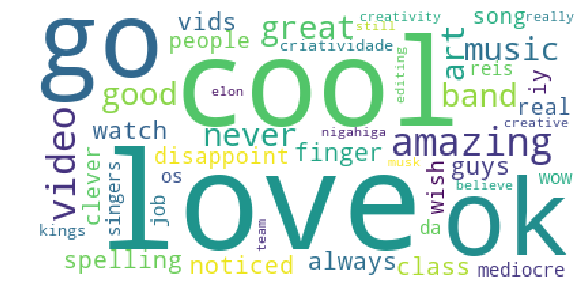

In [60]:
wordcloud = WordCloud(background_color='white').generate(' '.join(positive))
plt.figure( figsize=(13,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

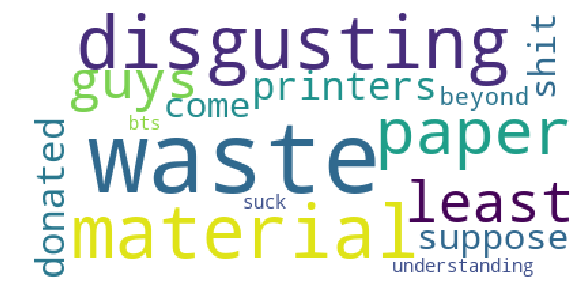

In [61]:
wordcloud = WordCloud(background_color='white').generate(' '.join(negative))
plt.figure( figsize=(13,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

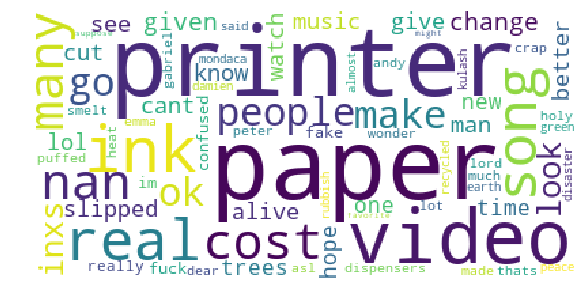

In [62]:
wordcloud = WordCloud(background_color='white').generate(' '.join(neutral))
plt.figure( figsize=(13,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()